# Comparing MLP and Convolutional Models

In this week's homework, we'll use PyTorch to compare the performance of multi-layer perceptrons (MLP's; the kind of model we've looked at so far) against _convolutional_ neural networks (CNN's). We'll talk about convolutions in class on Monday, but you can get started on the MLP part of the homework as soon as you're ready. For our comparison we'll go back to the CIFAR-10 dataset, since it's a bit less chaotic than CIFAR-100.

As with the last homework, I have some guidelines about what parts of the homework are necessary for different grades:

- The basic version, for a C, is to define and train an MLP and a CNN.
- On top of that, the B level work requires you to analyze your results a bit. I'll describe this in more detail later in the notebook after the code that sets up and trains the networks.
- For an A, you'll need to finish the activation map visualization in the last section of this notebook. More details on that later on.

The rest of the document is organized into sections which are labeled with the grade they correspond to.

## Data Setup

The first section of the notebook gets the dataset and sets up the transforms we need. The code in this section is complete, although you may need to change the dataset path or change the `transform` definition to match your version of torchvision.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [17]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ConvertImageDtype(),
    # Depending on your torchvision version you may need to change these:
    # - If you don't have torchvision.transforms.v2, then import torchvision.transforms
    #   instead and use ToTensor() to replace _both_ of the transforms above.
    # - If you have v2 but it says ToImage() is undefined, then use ToImageTensor() instead.
])

# If you already have the CIFAR10 data downloaded from the in-class notebook, you can change the path here
# to point to it so you avoid downloading a second copy.
cifar = torchvision.datasets.CIFAR10("../../data/torch/cifar", download=True, transform=transform)
train_size = int(0.8 * len(cifar))
train_data, valid_data = torch.utils.data.random_split(cifar, [train_size, len(cifar) - train_size])

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(len(cifar))

Files already downloaded and verified
50000


In [46]:
mean = []
for x, _ in cifar:
    mean.append(torch.mean(x, dim=(1, 2)))
mean = torch.stack(mean, dim=0).mean(dim=0)
std = []
for x, _ in cifar:
    std.append(((x - mean[:,np.newaxis,np.newaxis]) ** 2).mean(dim=(1, 2)))
std = torch.stack(std, dim=0).mean(dim=0).sqrt()
print(mean, std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [ ]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

normalize = transforms.Normalize(cifar_mean, cifar_std)

## Models and Training (C)

First, define an MLP model for the CIFAR dataset. An MLP, also called a fully-connected network, consists of linear computations alternated with nonlinear activation functions, just like every network we've looked at in this class so far. This is very similar to what we did in clas on Wednesday and lab on Friday.

In [ ]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.model(x.reshape(-1, 3*32*32).squeeze(dim=0))

Now let's define a training function for our MLP. As usual, you may want to add more arguments to the training function. For the latter parts of the notebook, it will be helpful if your training function returns both the model and a list of the training and validation accuracies for each epoch.

In [ ]:
def train(model_class=MLP, lr=1e-3, epochs=10, batch_size=64):
 
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
    print(device)
    network = model_class().to(device)
    loss = nn.CrossEntropyLoss()
    opt = optim.SGD(network.parameters(), momentum=0.9, lr=lr, weight_decay=0)
    train_accs = []
    valid_accs = []
    
    for i in range(epochs):

        for batch_xs, batch_ys in data_loader:
            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)
            batch_xs = normalize(batch_xs)
            preds = network(batch_xs)
            loss_val = loss(preds, batch_ys)
            opt.zero_grad()
            loss_val.backward()
            opt.step()
        
        for batch_xs, batch_ys in valid_loader:

            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)
            batch_xs = normalize(batch_xs)
            preds = network(batch_xs)
            valid_accs.append((preds.argmax(dim=1) == batch_ys).float().mean())
        
        print("Epoch:", i, "Validation accuracy:", torch.tensor(valid_accs).mean().item())

    return network, train_accs, valid_accs

In [ ]:
%%time
mlp_model, mlp_train_accs, mlp_valid_accs = train(model_class=MLP, lr=5e-3, epochs=15, batch_size=64)

cpu
Epoch: 0 Validation accuracy: 0.4468550980091095
Epoch: 1 Validation accuracy: 0.4641222059726715
Epoch: 2 Validation accuracy: 0.47438958287239075
Epoch: 3 Validation accuracy: 0.4836285710334778
Epoch: 4 Validation accuracy: 0.48859474062919617
Epoch: 5 Validation accuracy: 0.4947584867477417
Epoch: 6 Validation accuracy: 0.498492956161499
Epoch: 7 Validation accuracy: 0.5004354119300842
Epoch: 8 Validation accuracy: 0.5040804147720337
Epoch: 9 Validation accuracy: 0.5054836869239807
Epoch: 10 Validation accuracy: 0.5073646306991577
Epoch: 11 Validation accuracy: 0.5089486837387085
Epoch: 12 Validation accuracy: 0.50960773229599
Epoch: 13 Validation accuracy: 0.5101014971733093
Epoch: 14 Validation accuracy: 0.5107550621032715
CPU times: user 7min 42s, sys: 6.11 s, total: 7min 48s
Wall time: 1min 57s


Now you can define a CNN for the same task.

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.model(x)

Now you can train your CNN. You should be able use the same `train` function but pass it `model_class=CNN` (you may need to change some other hyperparameters to get good results).

In [ ]:
%%time
cnn_model, cnn_train_accs, cnn_valid_accs = train(model_class=CNN, lr=8e-3, epochs=15, batch_size=64)

cpu
Epoch: 0 Validation accuracy: 0.5014928579330444
Epoch: 1 Validation accuracy: 0.5137838125228882
Epoch: 2 Validation accuracy: 0.5341693162918091
Epoch: 3 Validation accuracy: 0.5486415028572083
Epoch: 4 Validation accuracy: 0.5607882142066956
Epoch: 5 Validation accuracy: 0.5697319507598877
Epoch: 6 Validation accuracy: 0.5754805207252502
Epoch: 7 Validation accuracy: 0.5804264545440674
Epoch: 8 Validation accuracy: 0.5858324766159058
Epoch: 9 Validation accuracy: 0.5895799994468689
Epoch: 10 Validation accuracy: 0.5935328602790833
Epoch: 11 Validation accuracy: 0.5956408977508545
Epoch: 12 Validation accuracy: 0.598251461982727
Epoch: 13 Validation accuracy: 0.6004464030265808
Epoch: 14 Validation accuracy: 0.6020634174346924
CPU times: user 12min 7s, sys: 7.21 s, total: 12min 14s
Wall time: 3min 4s


Given how long it takes to train the CNN model, now might be a good time to talk about saving and loading models. The cell below will save your CNN model to the file `cnn_model.pt`.

In [ ]:
torch.save(cnn_model.state_dict(), "cnn_model.pt")

If you have the file `cnn_model.pt` on your system, then you can load it with this code:

In [ ]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("cnn_model.pt"))

/tmp/ipykernel_130800/1420923919.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("cnn_model.pt"))


<All keys matched successfully>

## Analysis (B)

In this section, we'll do some minor analysis of the results of our experiment above. Let's compare

- the time taken to train each model,
- the validation accuracy over time,
- the total number of parameters in each model.

That last measurement, the total number of parameters, is something you'll need to compute pased on your network architecture. When I say number of parameters here, I'm referring to the total number of dimensions in the parameter space. That is, the total number of individual real numbers in our parameters. For example, a matrix of size 100x10 has 1,000 parameters.

I'm not asking for anything specific here, I'm just looking for you to think about the models we're using and their relative merits. If you think of something else that might be useful to compare the two networks, mention that as well.

### What Do We Learn?
- In terms of the time it takes to train each model, they're roughly comparable at just over 1 minute running on the CUDA-enabled GPUs.
- The validation accuracy of the CNN model is significantly higher both initially and over time. I have adjusted the MLP hyperparameters a bit and no matter what I choose, the CNN simply performs better. The validation accuracy of the MLP tops out at roughly \~51%, while the CNN tops out at over \~60%. An interesting detail is that with the learning rate I select, both the CNN and the MLP start at roughly the same validation accuracy (~47%) but the CNN plateaus much later than the MLP.
- In terms of parameters, I did some math and found that the MLP has 823936 parameters in the formulation I produced while the CNN has 23584 parameters. Therefore, the MLP has over 33 times more parameters than the CNN. A whole order of magnitude more parameters is a pretty bad look unfortunately.

### Relative Merits of the Models
- In this case, I think that the CNN just had the MLP beat for the most part.
- Its reduced number of parameters means that overfitting is less likely (unless there's something else in the CNN formulation that I'm missing that would change this fact).
- The CNN also obtains much higher validation accuracy than the MLP even without extensive hyperparameter tweaking.
- Finally, the CNN allows for slightly more flexibility in terms of how we want to do training because of the interleaving of `ReLU`, `MaxPool2d` and `AvgPool2d` rather than relying on the traditional activation functions of an MLP.

## Interpretation (A)

In this section, we'll explore our CNN and try to understand how it learns to recognize different objects. There are several approaches to this problem. For today we'll look at a simple one that only works for the first convolutional layer. If we plot the weights of the layer as image data, we can visualize the kinds of patterns the convolution is scanning for. In order to do this, you'll need to normalize each kernel to the range [0, 1], then transpose the axis to format the weights as image data, then use the `imshow` function from `matplotlib.pyplot`. The weights of a convolutional layer `conv` are stored as a tensor of shape `Cin, Cout, H, W` in `conv.weight`.

If you have a torch tensor `x` and you want to display it with `imshow` you'll need to convert it to numpy by calling `x.detach().numpy()`.

Once you've got the plots displaying, take a minute to think about convolutions and try to tell me what the plots mean in terms of how the network recognizes images. (I'm being deliberately a bit vague about this.)

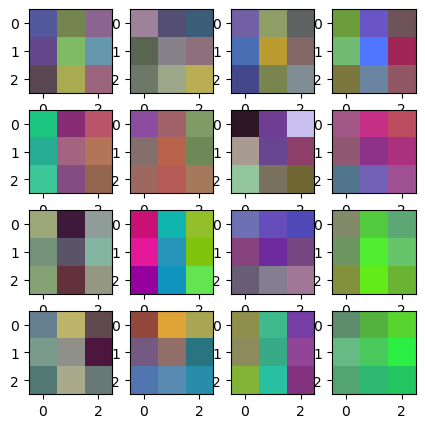

In [ ]:
# If your first convolutional layer has fewer than 16 output channels then you'll need to
# change the number of plots here.

# Getting our model layers first and putting them into a dictionary
named_module_dict = dict(loaded_model.named_parameters())

# Getting the first convolutional layer as a tensor
conv = named_module_dict['model.0.weight'].data

# Normalizing it so that all values are in [0,1]
conv -= conv.min()
conv /= conv.max()

fig, axs = plt.subplots(4, 4, figsize=(5, 5))
for i in range(4):
    for j in range(4):
        c = 4 * i + j

        axs[i,j].imshow(conv[c].detach().numpy())
plt.show()

### What This Means
- Okay so these are the 16 kernels that the CNN network produces in its first convolutional layer.
- A lot of them are more abstract and its hard to tell what exactly they're doing but some of them make sense from a human-readable perspective.
- I'm going to number the kernels 1-16 going from top-left to bottom-right for ease of speaking.
- Clearly, 12 and 16 are designed to recognize grass and/or natural scenes. Apparently, our model thinks these are important in classifying data because it has two of them that are very similar.
- 14 is a very interesting kernel because the bottom half being entirely blue leads me to believe it is designed to recognize either boats or airplanes. 11 is similar but the blue is on top, leading me to suspect that this one is specifically for airplanes.
- 9 and 13 are very similar too. I can't tell if they're trying to recognize man-made structures with the grey and brown or something else. Perhaps these are for the dogs and cats?
- 10 is a weird one. I have no idea what is going on there or why it produces such clear color delineations.